In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
def generate_data(n=100, sigma=0.01):
    '''
    data generated as follows:
        t = U(0, 2*pi),
        x = np.sin(t) + n_1,
        y = np.cos(t) + n_2,
        where n_1, n_2 ~i.i.d.~ N(0, 0.01)
    '''

    t = np.random.uniform(low=0, high=2*np.pi, size=n)
    x = np.sin(t) + np.random.normal(loc=0, scale=sigma, size=n)
    y = np.cos(t) + np.random.normal(loc=0, scale=sigma, size=n)

    return x, y

In [3]:
def gaussian_kernel(x, y=None, beta=1):
    '''
    compute the kernel matrix for arrays x and y where
    the kernel, k, is defined as k(x, y) = exp(-(x-y)^2)
    '''

    if x.ndim == 1:
        x = np.expand_dims(x, axis=1)
    if y is None:
        y = x.copy()
    elif y.ndim == 1:
        y = np.expand_dims(y, axis=1)
    assert x.ndim == 2 and y.ndim == 2

    difference = np.expand_dims(x, axis=1) - np.expand_dims(y, axis=0)
    norm = np.linalg.norm(difference, axis=2)
    kernel_matrix = np.exp(-beta*norm**2)

    return kernel_matrix

In [4]:
def incomplete_cholesky(K, eta=0.):
    '''
    incomplete cholesky decomposition 
    implementation as given in the extract
    '''

    ell = K.shape[0]
    R = np.zeros((ell, ell))
    d = np.diag(K).copy()

    nu = np.zeros(ell)
    j = 0
    I = np.zeros(ell, dtype=int)
    a = np.max(d)

    while a >= eta and j < ell:
        I[j] = np.argmax(d); nu[j] = np.sqrt(a)
        R[j, :] = (K[I[j], :] - R.T @ R[:, I[j]]) / nu[j]
        d = d - R[j, :] ** 2
        j += 1; a = np.max(d)

    return R[:j, :]

In [5]:
def plot(x, y, color='black',
         xticks=None, yticks=None,
         xlabel=None, xlabel_color='black',
         ylabel=None, ylabel_color='black',
         title=None, title_color='black',
         label_size=10, title_size=10, ticks_size=10,
         label_weight='normal', title_weight='normal',
         x_margin=0.1, y_margin=0.1,
         axs=None):

    if axs is None:
        _, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.scatter(x, y, s=10, color=color)
    if xticks is not None:
        axs.set_xlim(min(np.min(x), np.min(xticks))-x_margin, max(np.max(x), np.max(xticks))+x_margin)
        axs.set_xticks(xticks, labels=xticks, fontsize=ticks_size)
    if yticks is not None:
        axs.set_ylim(min(np.min(y), np.min(yticks))-y_margin, max(np.max(y), np.max(yticks))+y_margin)
        axs.set_yticks(yticks, labels=yticks, fontsize=ticks_size)
    if xlabel is not None:
        axs.set_xlabel(xlabel, color=xlabel_color, fontsize=label_size, weight=label_weight)
    if ylabel is not None:
        axs.set_ylabel(ylabel, color=ylabel_color, fontsize=label_size, weight=label_weight)
    if title is not None:
        axs.set_title(title, color=title_color, fontsize=title_size, weight=title_weight)
    axs.grid()

    return axs

In [6]:
# parameters for data generation process
n, sigma = 1000, 0.01
# sets the width of the the Gaussian kernel
beta = 1
# threshold on residual norm for incomplete cholesky implementation
eta = 0.01

In [7]:
X, Y = generate_data(n, sigma)
H = np.eye(n) - np.ones((n, n)) / n
K = gaussian_kernel(X, None, beta); K_tilde = H @ K @ H
L = gaussian_kernel(Y, None, beta); L_tilde = H @ L @ H

In [8]:
R = incomplete_cholesky(K_tilde, eta); r = R.shape[0]
S = incomplete_cholesky(L_tilde, eta); s = S.shape[0]

In [9]:
A = np.block([
    [np.zeros((r, r)), R @ S.T],
    [S @ R.T, np.zeros((s, s))]
])
gamma, coefs = eigh(A, subset_by_index=(r+s-1,r+s-1))

In [10]:
alpha_tilde = coefs[:r]    # alpha corresponds to K_tilde, which is formed using representations (arranged in R)
beta_tilde = coefs[-s:]    # beta  corresponds to L_tilde, which is formed using representations (arranged in S)
f = (R.T @ alpha_tilde).ravel()    # alpha_tilde = R @ alpha, so R.T @ alpha_tilde = K_tilde @ alpha
g = (S.T @ beta_tilde).ravel()     # beta_tilde  = S @ beta,  so S.T @ beta_tilde  = L_tilde @ beta

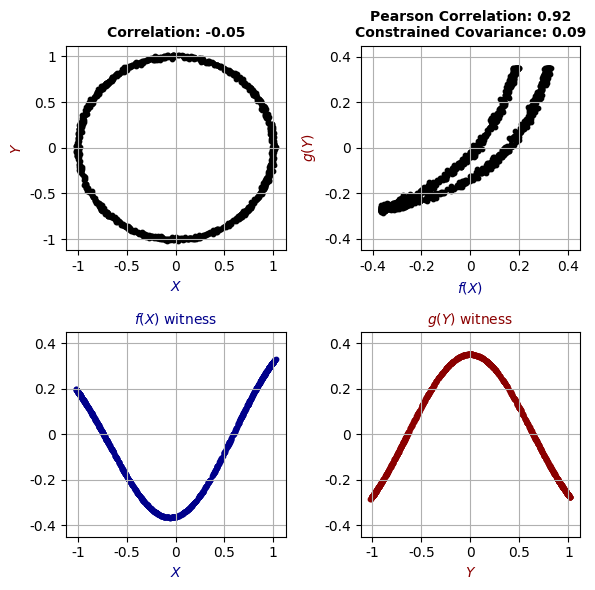

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

plot(
    X, Y, color='black',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-1, -0.5, 0, 0.5, 1),
    xlabel=r'$X$', xlabel_color='darkblue',
    ylabel=r'$Y$', ylabel_color='darkred',
    title=f'Correlation: {pearsonr(X, Y).statistic:.2f}', title_color='black',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='bold',
    x_margin=0.1, y_margin=0.1,
    axs=axs[0, 0]
)

plot(
    f, g, color='black',
    xticks=(-0.4, -0.2, 0, 0.2, 0.4), yticks=(-0.4, -0.2, 0, 0.2, 0.4),
    xlabel=r'$f(X)$', xlabel_color='darkblue',
    ylabel=r'$g(Y)$', ylabel_color='darkred',
    title=f'Pearson Correlation: {pearsonr(f, g).statistic:.2f}\nConstrained Covariance: {gamma[0]/n:.2f}', title_color='black',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='bold',
    x_margin=0.05, y_margin=0.05,
    axs=axs[0, 1]
)

plot(
    X, f, color='darkblue',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-0.4, -0.2, 0, 0.2, 0.4),
    xlabel=r'$X$', xlabel_color='darkblue',
    title=r'$f(X)$ witness', title_color='darkblue',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='normal',
    x_margin=0.1, y_margin=0.05,
    axs=axs[1, 0]
)

plot(
    Y, g, color='darkred',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-0.4, -0.2, 0, 0.2, 0.4),
    xlabel=r'$Y$', xlabel_color='darkred',
    title=r'$g(Y)$ witness', title_color='darkred',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='normal',
    x_margin=0.1, y_margin=0.05,
    axs=axs[1, 1]
)

fig.tight_layout()

In [12]:
# n*eps, where eps is the regularisation added to the constraints
n_eps = 10
# with n = 1000, this implies eps = 0.01

In [13]:
A = np.block([
    [np.zeros((r, r)), R @ S.T],
    [S @ R.T, np.zeros((s, s))]
])
B = np.block([
    [R @ R.T + n_eps*np.eye(r), np.zeros((r, s))],
    [np.zeros((s, r)), S @ S.T + n_eps*np.eye(s)]
])
gamma, coefs = eigh(A, B, subset_by_index=(r+s-1,r+s-1))

In [14]:
alpha = coefs[:r]; f = (R.T @ alpha).ravel()
beta = coefs[-s:]; g = (S.T @ beta).ravel()

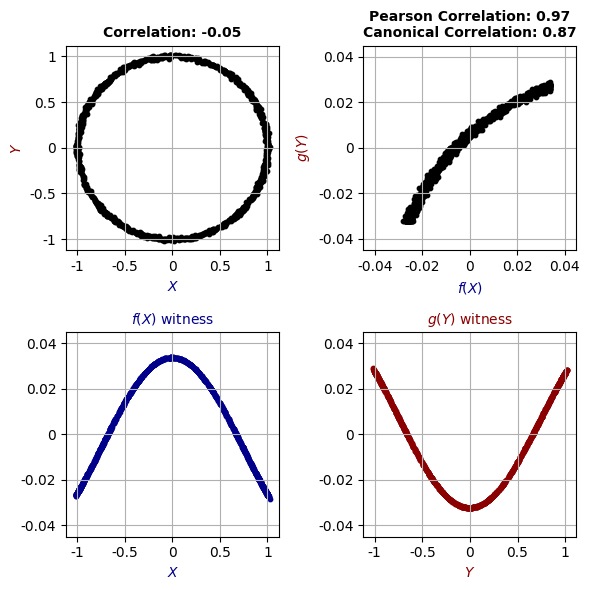

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

plot(
    X, Y, color='black',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-1, -0.5, 0, 0.5, 1),
    xlabel=r'$X$', xlabel_color='darkblue',
    ylabel=r'$Y$', ylabel_color='darkred',
    title=f'Correlation: {pearsonr(X, Y).statistic:.2f}', title_color='black',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='bold',
    x_margin=0.1, y_margin=0.1,
    axs=axs[0, 0]
)

plot(
    f, g, color='black',
    xticks=(-0.04, -0.02, 0, 0.02, 0.04), yticks=(-0.04, -0.02, 0, 0.02, 0.04),
    xlabel=r'$f(X)$', xlabel_color='darkblue',
    ylabel=r'$g(Y)$', ylabel_color='darkred',
    title=f'Pearson Correlation: {pearsonr(f, g).statistic:.2f}\nCanonical Correlation: {gamma[0]:.2f}', title_color='black',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='bold',
    x_margin=0.005, y_margin=0.005,
    axs=axs[0, 1]
)

plot(
    X, f, color='darkblue',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-0.04, -0.02, 0, 0.02, 0.04),
    xlabel=r'$X$', xlabel_color='darkblue',
    title=r'$f(X)$ witness', title_color='darkblue',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='normal',
    x_margin=0.1, y_margin=0.005,
    axs=axs[1, 0]
)

plot(
    Y, g, color='darkred',
    xticks=(-1, -0.5, 0, 0.5, 1), yticks=(-0.04, -0.02, 0, 0.02, 0.04),
    xlabel=r'$Y$', xlabel_color='darkred',
    title=r'$g(Y)$ witness', title_color='darkred',
    label_size=10, title_size=10, ticks_size=10,
    label_weight='normal', title_weight='normal',
    x_margin=0.1, y_margin=0.005,
    axs=axs[1, 1]
)

fig.tight_layout()